In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("dgcnn/pytorch")

import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from data import ModelNet40
from model import PointNet, DGCNN
import numpy as np
from torch.utils.data import DataLoader
from util import cal_loss, IOStream
import sklearn.metrics as metrics


# # Set the device
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
device = 'cuda'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
parser = argparse.ArgumentParser(description='Point Cloud Recognition')
parser.add_argument('--exp_name', type=str, default='exp', metavar='N',
                    help='Name of the experiment')
parser.add_argument('--model', type=str, default='dgcnn', metavar='N',
                    choices=['pointnet', 'dgcnn'],
                    help='Model to use, [pointnet, dgcnn]')
parser.add_argument('--dataset', type=str, default='modelnet40', metavar='N',
                    choices=['modelnet40'])
parser.add_argument('--batch_size', type=int, default=32, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--test_batch_size', type=int, default=16, metavar='batch_size',
                    help='Size of batch)')
parser.add_argument('--epochs', type=int, default=250, metavar='N',
                    help='number of episode to train ')
parser.add_argument('--use_sgd', type=bool, default=True,
                    help='Use SGD')
parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
                    help='learning rate (default: 0.001, 0.1 if using sgd)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--no_cuda', type=bool, default=False,
                    help='enables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--eval', type=bool,  default=False,
                    help='evaluate the model')
parser.add_argument('--num_points', type=int, default=1024,
                    help='num of points to use')
parser.add_argument('--dropout', type=float, default=0.5,
                    help='dropout rate')
parser.add_argument('--emb_dims', type=int, default=1024, metavar='N',
                    help='Dimension of embeddings')
parser.add_argument('--k', type=int, default=20, metavar='N',
                    help='Num of nearest neighbors to use')
parser.add_argument('--model_path', type=str, default='', metavar='N',
                    help='Pretrained model path')
args = parser.parse_args([])

In [6]:
if not os.path.exists('checkpoints'):
        os.makedirs('checkpoints')
if not os.path.exists('checkpoints/'+args.exp_name):
    os.makedirs('checkpoints/'+args.exp_name)
if not os.path.exists('checkpoints/'+args.exp_name+'/'+'models'):
    os.makedirs('checkpoints/'+args.exp_name+'/'+'models')
os.system('cp main.py checkpoints'+'/'+args.exp_name+'/'+'main.py.backup')
os.system('cp model.py checkpoints' + '/' + args.exp_name + '/' + 'model.py.backup')
os.system('cp util.py checkpoints' + '/' + args.exp_name + '/' + 'util.py.backup')
os.system('cp data.py checkpoints' + '/' + args.exp_name + '/' + 'data.py.backup');

In [7]:
io = IOStream('checkpoints/' + args.exp_name + '/run.log')
io.cprint(str(args))

args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    io.cprint(
        'Using GPU : ' + str(torch.cuda.current_device()) + ' from ' + str(torch.cuda.device_count()) + ' devices')
    torch.cuda.manual_seed(args.seed)
else:
    io.cprint('Using CPU')

Namespace(batch_size=32, dataset='modelnet40', dropout=0.5, emb_dims=1024, epochs=250, eval=False, exp_name='exp', k=20, lr=0.001, model='dgcnn', model_path='', momentum=0.9, no_cuda=False, num_points=1024, seed=1, test_batch_size=16, use_sgd=True)
Using GPU : 0 from 1 devices


In [39]:
train_loader = DataLoader(ModelNet40(partition='train', num_points=args.num_points), num_workers=8,
                          batch_size=args.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=8,
                         batch_size=args.test_batch_size, shuffle=True, drop_last=False)

dgcnn/pytorch/data.py:40: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  for h5_name in glob.glob(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048', 'ply_data_%s*.h5'%partition)):


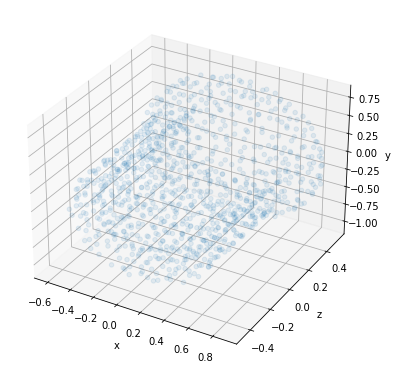

In [41]:
from plot_utils import plot_pointcloud, plot_pointcloud_from_mesh, plot_render, plot_mesh

#plot random point
for data, label in train_loader:
    data, label = data.to(device), label.to(device).squeeze()
    data = data.permute(0, 2, 1)
    plot_pointcloud(data[0].permute(1,0))
    break

In [42]:
device = torch.device("cuda" if args.cuda else "cpu")

#Try to load models
if args.model == 'pointnet':
    model = PointNet(args).to(device)
elif args.model == 'dgcnn':
    model = DGCNN(args).to(device)
else:
    raise Exception("Not implemented")
print(str(model))

model = nn.DataParallel(model)
print("Let's use", torch.cuda.device_count(), "GPUs!")

if args.use_sgd:
    print("Use SGD")
    opt = optim.SGD(model.parameters(), lr=args.lr*100, momentum=args.momentum, weight_decay=1e-4)
else:
    print("Use Adam")
    opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)

scheduler = CosineAnnealingLR(opt, args.epochs, eta_min=args.lr)

criterion = cal_loss

DGCNN(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [ ]:
best_test_acc = 0
for epoch in range(args.epochs):
    scheduler.step()
    ####################
    # Train
    ####################
    train_loss = 0.0
    count = 0.0
    model.train()
    train_pred = []
    train_true = []
    for data, label in train_loader:
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        opt.zero_grad()
        logits = model(data)
        loss = criterion(logits, label)
        loss.backward()
        opt.step()
        preds = logits.max(dim=1)[1]
        count += batch_size
        train_loss += loss.item() * batch_size
        train_true.append(label.cpu().numpy())
        train_pred.append(preds.detach().cpu().numpy())
    train_true = np.concatenate(train_true)
    train_pred = np.concatenate(train_pred)
    outstr = 'Train %d, loss: %.6f, train acc: %.6f, train avg acc: %.6f' % (epoch,
                                                                             train_loss*1.0/count,
                                                                             metrics.accuracy_score(
                                                                                 train_true, train_pred),
                                                                             metrics.balanced_accuracy_score(
                                                                                 train_true, train_pred))
    io.cprint(outstr)

    ####################
    # Test
    ####################
    test_loss = 0.0
    count = 0.0
    model.eval()
    test_pred = []
    test_true = []
    for data, label in test_loader:
        data, label = data.to(device), label.to(device).squeeze()
        data = data.permute(0, 2, 1)
        batch_size = data.size()[0]
        logits = model(data)
        loss = criterion(logits, label)
        preds = logits.max(dim=1)[1]
        count += batch_size
        test_loss += loss.item() * batch_size
        test_true.append(label.cpu().numpy())
        test_pred.append(preds.detach().cpu().numpy())
    test_true = np.concatenate(test_true)
    test_pred = np.concatenate(test_pred)
    test_acc = metrics.accuracy_score(test_true, test_pred)
    avg_per_class_acc = metrics.balanced_accuracy_score(test_true, test_pred)
    outstr = 'Test %d, loss: %.6f, test acc: %.6f, test avg acc: %.6f' % (epoch,
                                                                          test_loss*1.0/count,
                                                                          test_acc,
                                                                          avg_per_class_acc)
    io.cprint(outstr)
    if test_acc >= best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'checkpoints/%s/models/model.t7' % args.exp_name)

/disk_c/cole/miniconda3/envs/pytorch3d/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train 0, loss: 2.801878, train acc: 0.430578, train avg acc: 0.252694
Test 0, loss: 2.395266, test acc: 0.485818, test avg acc: 0.369948
Train 1, loss: 2.220026, train acc: 0.629886, train avg acc: 0.448337
Test 1, loss: 2.040537, test acc: 0.681929, test avg acc: 0.539913
Train 2, loss: 2.062309, train acc: 0.699613, train avg acc: 0.544337
Test 2, loss: 1.921933, test acc: 0.772690, test avg acc: 0.682052
Train 3, loss: 1.958728, train acc: 0.742264, train avg acc: 0.606019
Test 3, loss: 1.831240, test acc: 0.794571, test avg acc: 0.692895
Train 4, loss: 1.901530, train acc: 0.768628, train avg acc: 0.643618
Test 4, loss: 1.774773, test acc: 0.828606, test avg acc: 0.727820
Train 5, loss: 1.862007, train acc: 0.786747, train avg acc: 0.669955
Test 5, loss: 1.732275, test acc: 0.841167, test avg acc: 0.775023
Train 6, loss: 1.820668, train acc: 0.802423, train avg acc: 0.694355
Test 6, loss: 1.780534, test acc: 0.816856, test avg acc: 0.751605
Train 7, loss: 1.800338, train acc: 0.810

Test 59, loss: 1.535583, test acc: 0.892220, test avg acc: 0.846936
